<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-in-Data" data-toc-modified-id="Read-in-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read in Data</a></span></li><li><span><a href="#Read-Surveys" data-toc-modified-id="Read-Surveys-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read Surveys</a></span></li><li><span><a href="#Create-DBN-columns" data-toc-modified-id="Create-DBN-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create DBN columns</a></span></li><li><span><a href="#Convert-columns-to-numeric" data-toc-modified-id="Convert-columns-to-numeric-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Convert columns to numeric</a></span></li><li><span><a href="#Condense-datasets-to-make-DBN-unique" data-toc-modified-id="Condense-datasets-to-make-DBN-unique-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Condense datasets to make DBN unique</a></span></li><li><span><a href="#Make-AP-scores-numeric" data-toc-modified-id="Make-AP-scores-numeric-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Make AP scores numeric</a></span></li><li><span><a href="#Merge-datasets" data-toc-modified-id="Merge-datasets-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Merge datasets</a></span></li><li><span><a href="#Get-State-Code-from-DBN" data-toc-modified-id="Get-State-Code-from-DBN-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Get State Code from DBN</a></span></li><li><span><a href="#Find-correlations-to-SAT-score" data-toc-modified-id="Find-correlations-to-SAT-score-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Find correlations to SAT score</a></span></li></ul></div>

# Read in Data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("sat/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read Surveys

In [2]:
import pandas
all_survey = pandas.read_csv("sat/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("sat/survey_d75.txt", delimiter="\t", encoding='windows-1252')

survey = pandas.concat([all_survey, d75_survey], axis=0)
survey["DBN"] = survey["dbn"]  

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Create DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets to make DBN unique

In [5]:
class_size = data["class_size"]                    #condensing to make DBN in class_size unique 
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]  #schoolyear preventing demographics uniqueness

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]  #Demographic and Cohort preventing graduation uniqueness
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Make AP scores numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Merge datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Get State Code from DBN

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations to SAT score

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"][['sat_score','CSD']]
print(type(correlations))
print(correlations)


<class 'pandas.core.series.Series'>
sat_score    1.000000
CSD          0.042948
Name: sat_score, dtype: float64


C:\Anaconda\lib\site-packages\pandas\core\series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


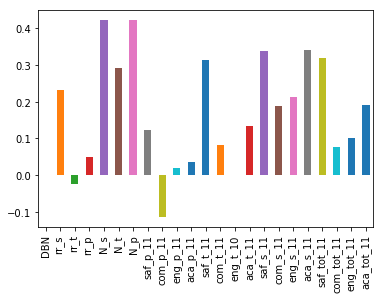

In [10]:
%matplotlib inline 

combined.corr()['sat_score'][survey_fields].plot.bar()

N_s,N_t,N_p have high correlations, they are correlated to total_enrollment which has high correlations, so this insight is expected.
rr_s represents student response rate. 
Safety and respect scores saf_t_11, saf_s_11, saf_tot_11 have above 0.3 correlation with sat_scores. saf_p_11 parents correlate less probably because they are further from the learning environment, thus have a weaker appreciation of safety and respect in education.

aca_s_11 is higher than aca_p_11 or aca_t_11. How students view academic expectations have a higher correlation with their score. Maybe intrinsic motivation is better than extrinsic motivation.

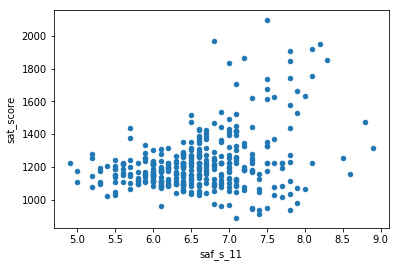

In [11]:
combined.plot.scatter('saf_s_11','sat_score')

There is a cluster of lower sat_scores (below 1500) where the saf_s_11 is below 7.5. This may mean safety concerns and a disrespectful environment distract from effective learning. 
No school with a safety score lower than 6.5 has an average SAT score higher than 1500

In [12]:
import numpy as np
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)


C:\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


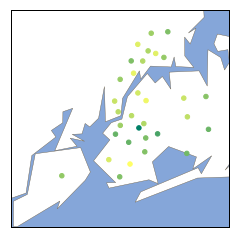

In [13]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
                 
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes,latitudes,s=20,zorder=2,latlon=True, c=districts["saf_tot_11"],cmap="summer")




The manhattan and queens boroughs are generally safer. Brooklyn is lower on the saf score 

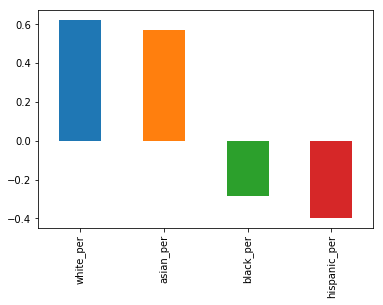

In [14]:
combined.corr()['sat_score'][['white_per','asian_per','black_per','hispanic_per']].plot.bar()

Percentage of whites have strong positive correlation while hispanics have strong negative correlation.
There may be less funding for schools in areas with high percentage of hispanics and blacks

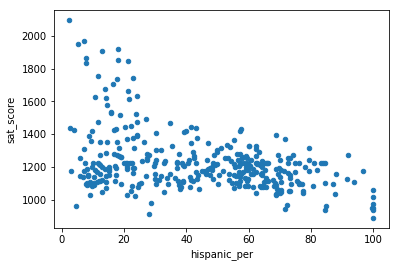

In [15]:
combined.plot.scatter('hispanic_per','sat_score')

There is a clear trend that schools with higher percentage of hispanic students (x-axis) have lower sat scores. the variation in sat scores decrease as the x-axis increases

In [16]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% }</style>"))
pandas.options.display.max_columns = 200
combined[combined['hispanic_per']>95]['ell_percent']


44     72.6
82     19.6
89     89.6
125    86.6
141    79.9
176    92.9
253    94.6
286    91.3
Name: ell_percent, dtype: float64

The schools listed above appear to primarily be geared towards recent immigrants to the US.
7 of the 8 schools with hispanic percentage greater than 95 have more than 70% english language learners. This may explain the lower sat scores

In [18]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,postcode,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,107.419512,131.425,101.890511,Total Cohort,STUYVESANT HIGH SCHOOL,2006,787,774,98.3%,774,98.3%,100%,770,97.8%,99.5%,4,0.5%,0.5%,0,0%,0%,10,1.3%,3,0.4%,2,28.000000,31.115789,24.105263,33.842105,0.0,STUYVESANT HIGH SCHOOL,20112012,0,30.3,3297,,,,,,,,,,,813,827,848,809,0.0,0.0,14.0,0.4,0,0,2377,72.1,40,1.2,80,2.4,780,23.7,1956.0,59.3,1341.0,40.7,93.0,95,33,3039.0,161.0,1062.0,8.4,7.5,7.7,7.7,7.2,5.6,0.0,7.2,7.5,6.2,7.0,7.9,7.7,6.4,6.9,7.6,02M475,Stuyvesant High School,Manhattan,M477,212-312-4800,212-587-3874,9.0,12,0.0,12.0,"M20, M22, M5, M9, S1115","1, 2, 3, A, C, E to Chambers St ; R to City Hall",345 Chambers Street,New York,NY,"10,282",http://stuy.edu,"3,292",0,Specialized School,Our goal is to provide our students with the b...,Mentoring in Intel Science Program through pro...,"Chinese (Mandarin), French, German, Italian, J...","Biology, Calculus AB, Calculus BC, Chemistry, ...",0,0,"Accelerated courses, Student Union, Yearly pub...","Basketball, Bowling, Cross Country, Fencing, G...","Basketball, Bowling, Cross Country, Fencing, G...",Cricket,0,0,"Bellevue Hospital Center, New York-Presbyteria...","New York Law School, New York University (NYU)...",0,"American Red Cross, UNICEF, American Cancer So...",0,"Citicorp, Goldman Sachs",Explorer Program,This is one of New York City's eight (8) Speci...,0,8:00 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",1.0,1.0,"31,703","1,084,587","1,000,160,215",Battery Park City-Lower Manhattan ...,40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS O

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

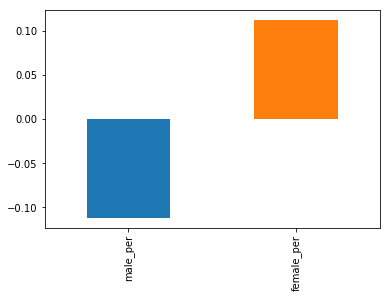

In [19]:
combined.corr()['sat_score'][['male_per','female_per']].plot.bar()

Percentage of both genders have little correlation with sat scores. Both genders perform equally

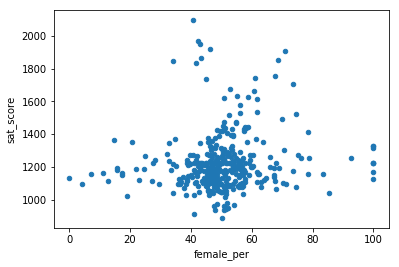

In [20]:
combined.plot.scatter("female_per", "sat_score")

There doesn't seem to be a correlation between gender and sat scores, but there is a cluster with high percentage of females and high sat scores.

In [21]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,postcode,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,107.419512,131.425,101.890511,Total Cohort,BARD HIGH SCHOOL EARLY COLLEGE,2006,139,134,96.4%,134,96.4%,100%,0,0%,0%,134,96.4%,100%,0,0%,0%,4,2.9%,1,0.7%,1,10.250000,20.975000,17.166667,24.250000,0.0,BARD HIGH SCHOOL EARLY COLLEGE,20112012,0,18.0,617,,,,,,,,,,,184,162,128,143,1.0,0.2,5.0,0.8,0,0,93,15.1,93,15.1,112,18.2,307,49.8,193.0,31.3,424.0,68.7,98.0,81,50,561.0,30.0,283.0,8.8,8.2,8.3,9.1,8.2,7.4,0.0,8.3,8.3,7.3,8.0,8.9,8.5,7.6,8.0,8.7,01M696,Bard High School Early College,Manhattan,M097,212-995-8479,212-777-4702,9.0,12,0.0,12.0,"M14A, M14D, M21, M22, M9",0,525 East Houston Street,New York,NY,"10,002",www.bard.edu/bhsec,560,0,0,Bard High School Early College Manhattan (BHSE...,"In the first two years at BHSEC, students unde...","Chinese (Mandarin), Latin, Spanish",0,0,0,"Bard Bulletin online newspaper, Bardvark stude...","Basketball, Soccer, Tennis, Volleyball","Basketball, Soccer, Tennis, Volleyball",Outdoor Track,Co-ed Ultimate Frisbee,"Lower East Side Girls Club, Third Street Music...",0,"Bard College, Bard College at Simon's Rock, Ro...","American Symphony Orchestra, American Museum o...",0,0,0,New York Academy of Sciences,0,Student Summer Orientation,9:00 AM,3:50 PM,This school will provide students with disabil...,ESL,Not Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",3.0,2.0,"1,002","1,004,062","1,003,250,025",Lower East Side ...,40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000,169.000000,Total Cohort,ELEANOR ROOSEVELT HIGH SCHOOL,2006,127,127,100%,126,99.2%,99.2%,110,86.6%,86.6%,16,12.6%,12.6%,1,0.8

These schools appears to be very selective liberal arts schools that have high academic standards.

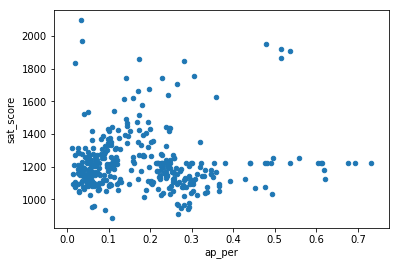

In [22]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

At AP percentages from  0 to 0.55, there are both high and low sat scores, above that, sat scores do not pass 1300.